In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def lscm(x, y, theta):

  x_next = np.sin(np.pi * (4 * theta * x * (1 - x) + (1 - theta) * np.sin(np.pi * y)))
  y_next = np.sin(np.pi * (4 * theta * y * (1 - y) + (1 - theta) * np.sin(np.pi * (x_next))))
  return x_next, y_next

def generate_lscm_secret_key():

  # Generate random initial states.
  x_0 = 0.8
  y_0 = 0.5
  theta = 0.99
  # Generate a random growth rate.
  r = 1.19 # initial r values

  # Generate random coefficients for the control parameters.
  p_1 = np.random.rand()      # for round 1
  p_2 = np.random.rand()      # for round 2

  # Return the secret key elements.
  return x_0, y_0, r, p_1, p_2, theta


In [3]:
img = cv2.imread('lungs.png')
print(img.shape)
# cv2.imshow('Image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

(2160, 3240, 3)


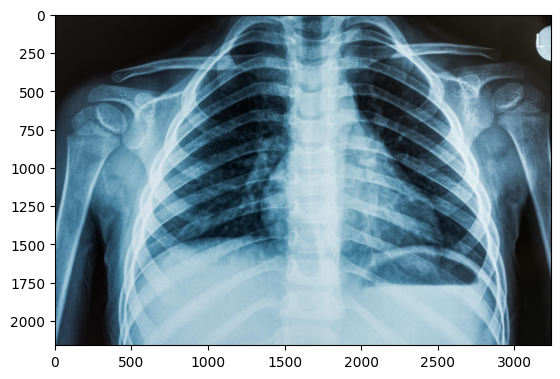

In [4]:
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [5]:
secret_key = generate_lscm_secret_key()

# Initialize the LSCM chaotic map with the secret key.
x = secret_key[0]
y = secret_key[1]
r = secret_key[2]
p1 = secret_key[3]
p2 = secret_key[4]
theta = secret_key[5]
# theta = r_cp = (r*p1)%1  # theta = r_cp
# Generate a sequence of LSCM chaotic map values.
M, N, le = img.shape
chaos = np.zeros((M,N))
x_sequence = []
y_sequence = []
# for i in range(50):
#   for j in range(50):
for i in range(M):
  for j in range(N):
    x_next, y_next = lscm(x, y, theta) # Round 1 only as of now  # rcp is the control paramater or theta
    x, y = x_next, y_next
    chaos[i][j] = x
#    chaos_y[i][j] = y0  # chaos matrix for y which can be combined to create position matrix PM instead of using cols
    x_sequence.append(x_next)
    y_sequence.append(y_next)

In [ ]:
#np.savetxt('chaos.txt', chaos)

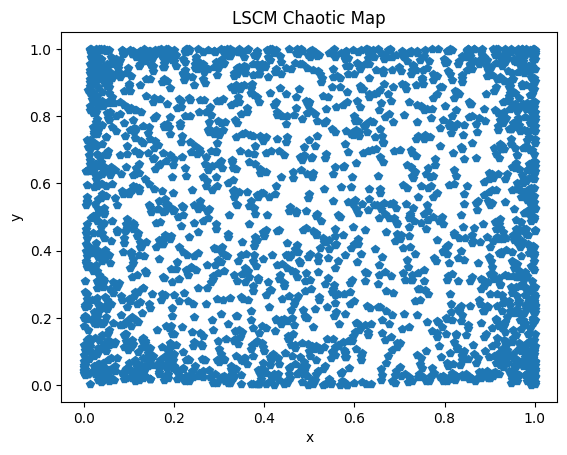

In [ ]:
# Plot the LSCM chaotic map sequence - 50*50 samples
plt.plot(x_sequence, y_sequence, 'p')
plt.xlabel('x')
plt.ylabel('y')
plt.title('LSCM Chaotic Map')
plt.show()

In [6]:
# Padding for Arnold cat as it can only work on square matrices
height, width, length = img.shape
m = max(height, width)
if height>width:
    padding=((0,0),(0,height-width), (0,0))
else:
    padding=((0,width-height),(0,0), (0,0))
image = np.pad(img, padding, mode='constant')
print(type(image))

<class 'numpy.ndarray'>


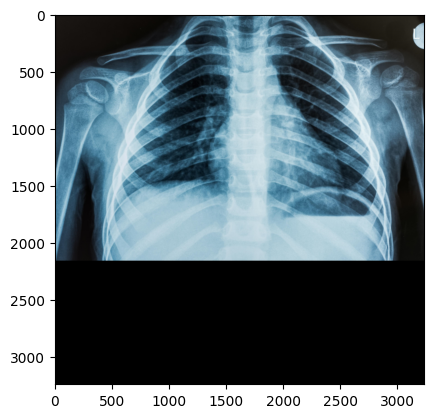

In [7]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [8]:
# Arnold cat map
# It is the issue in having red color
def arnold_cat_map(image, iterations):
    

    # Apply the map for the given number of iterations.
    
    for _ in range(iterations):
        new_image = np.zeros_like(image)
        for i in range(length):
            for y in range(height):
                for x in range(width):
                    new_x = (2 * x + y) % width
                    new_y = (x + y) % height
                    new_image[new_y, new_x][i] = image[y, x][i]

        image = new_image

    return image

In [9]:
transformed_image = arnold_cat_map(image, 10)

print(transformed_image.shape)

(3240, 3240, 3)


In [10]:
trn_img = transformed_image.astype(np.uint8)

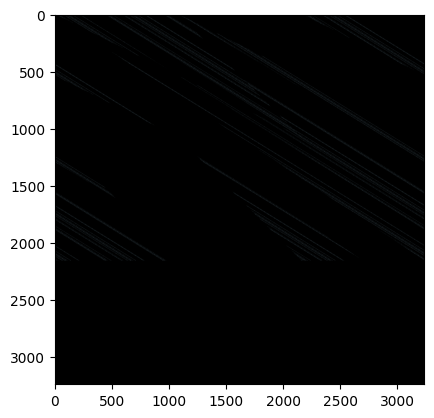

In [11]:
trn_rgb = cv2.cvtColor(trn_img, cv2.COLOR_BGR2RGB)
plt.imshow(trn_rgb)

In [12]:
# Permutaion
def generate_index_matrix(chaotic_matrix):
    index_matrix = np.argsort(chaotic_matrix, axis=0)
    return index_matrix

# Step 4: Form position matrix 'PM' using the index matrix 'I' as the row position
def generate_position_matrix(ind_m):
    height, width = ind_m.shape
    position_matrix = [[None]*width for i in range(height)]
    
    for i in range(height):
        for j in range(width):
            position_matrix[i][j] = (ind_m[i][j], j)
    return position_matrix


def lscm_permutation(P, S, PM):
    T = np.zeros_like(P)
    M, N, le = P.shape
    e = np.zeros(N)
    l=c = np.zeros(N)
    for k in range(le):
        for i in range(M):
            for j in range(N):
                x, y = PM[i][j]
                c[j] = P[x][y][k]
                e[j] = S[x][y]
            v=np.argsort(e)
            for j in range(N):
                vi = v[j]
                x, y = PM[i][j]
                T[x][y][k] = c[vi]
            
    return T


# Main function to perform permutation
def perform_image_permutation(plain_image):
    #chaotic_matrix = chaos
    index_matrix = generate_index_matrix(chaos)
    print(index_matrix.shape)
    position_matrix = generate_position_matrix(index_matrix)

    permuted_image = lscm_permutation(plain_image,chaos, position_matrix)
    return permuted_image, position_matrix

In [13]:
chaos.shape

(2160, 3240)

In [14]:
permuted_image, pem = perform_image_permutation(img) 

(2160, 3240)


In [15]:
pm = np.array(pem)

In [16]:
#pm_reshaped = pm.reshape(pm.shape[0], -1)
#np.savetxt('pm.txt', pm_reshaped)

In [17]:
perm = permuted_image.astype(np.uint8)

In [18]:
perm.shape

(2160, 3240, 3)

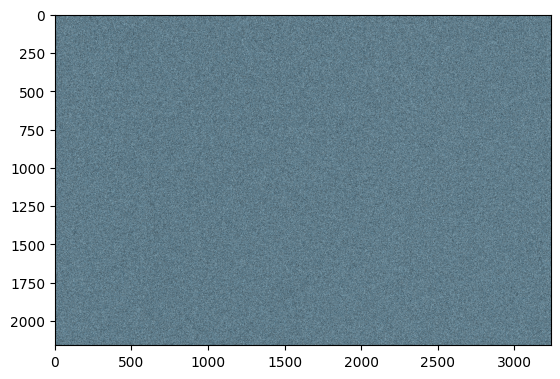

In [30]:
img_rgb = cv2.cvtColor(perm, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [20]:
# Diffusion
def diffusion(perm, chaotic, F):
    height, width, le = perm.shape
    print(perm[0])
    encrypted_image = np.zeros_like(perm).astype(np.float64)
    key = [120, 200]
    bit=2**32          # Scaling factor to scale chaotic value to significant range from (0,1) range to (0,255) range
    for k in range(le):
        for i in range(height):
            for j in range(width):
                if i == 0 and j==0:
                    # int() is provided to take the intger of that chaotic value
                    E_i = ((perm[0][0][k] + key[-1] + key[-2] + int((chaotic[i, j] * bit))) % F)  # Because on adding we get in array format of size one, so we index it as 0
                elif i ==0 and j == 1:
                    E_i = ((perm[0][1][k] + encrypted_image[i, j-1][k] + key[-1] + int((chaotic[i, j] * bit))) % F)
                else:
                    if j==0:# do this with j==0 or j==1
                        E_i = ((perm[i][j][k] + encrypted_image[i-1, width-1][k] + encrypted_image[i-1, width-2][k] + int((chaotic[i, j] * bit))) % F)
                    elif j==1:
                        E_i = ((perm[i][j][k] + encrypted_image[i, j-1][k] + encrypted_image[i-1, width-1][k] + int((chaotic[i, j] * bit))) % F)
                    else:
                        E_i = ((perm[i][j][k] + encrypted_image[i, j-1][k] + encrypted_image[i, j-2][k] + int((chaotic[i, j] * bit))) % F)
                
                encrypted_image[i, j][k] = E_i
    return encrypted_image.astype(np.uint8)

In [21]:
F = 256
encrypted_image = diffusion(perm, chaos, F)
encrypted_image.shape

[[ 30  34  35]
 [ 41  41  41]
 [232 225 208]
 ...
 [ 36  25  11]
 [ 87  73  55]
 [206 189 150]]


(2160, 3240, 3)

In [22]:
encry = encrypted_image.astype(np.uint8)

In [23]:
cv2.imwrite('encrypted_image.png', encry)

True

In [24]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
encry_rgb = cv2.cvtColor(encry, cv2.COLOR_BGR2RGB)

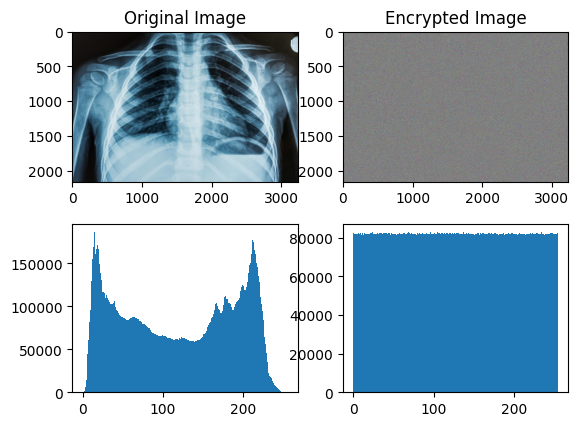

In [25]:
plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(encry_rgb)
plt.title("Encrypted Image")

plt.subplot(2, 2, 3)
plt.hist(img.ravel(), bins=256)

plt.subplot(2, 2, 4)
plt.hist(encry.ravel(), bins=256)

plt.show() 

In [26]:
# Decryption of Diffusion
def reverse_diffusion(encrypted_image, chaotic, F):
    encrypted_image = encrypted_image.astype(np.float64)
    height, width, le = encrypted_image.shape
    decrypted_image = np.zeros_like(encrypted_image)
    key = [120, 200]
    bit = 2**32  # Scaling factor to scale chaotic value
    for k in range(le):
        for i in range(height-1, -1, -1):
            for j in range(width-1, -1, -1):
                if i == 0 and j == 0:
                    E_i = (encrypted_image[0][0][k] - (key[-1] + key[-2] + int((chaotic[i, j] * bit))) % F)
                elif i == 0 and j == 1:
                    E_i = (encrypted_image[0][1][k] - (encrypted_image[i, j - 1][k] + key[-1] + int((chaotic[i, j] * bit))) % F)
                else:
                    if j == 0:
                        E_i = (encrypted_image[i][j][k] - (encrypted_image[i - 1, width - 1][k] + encrypted_image[i - 1, width - 2][k] + int((chaotic[i, j] * bit))) % F)
                    elif j == 1:
                        E_i = (encrypted_image[i][j][k] - (encrypted_image[i, j - 1][k] + encrypted_image[i - 1, width - 1][k] + int((chaotic[i, j] * bit))) % F)
                    else:
                        E_i = (encrypted_image[i][j][k] - (encrypted_image[i, j - 1][k] + encrypted_image[i, j - 2][k] + int((chaotic[i, j] * bit))) % F)

                decrypted_image[i, j][k] = E_i
    return decrypted_image.astype(np.uint8)

def reverse_lscm_permutation(T, S, PM):
    P = np.zeros_like(T)
    M, N, le = T.shape
    e = np.zeros(N)
    c = np.zeros(N)
    for a in range(le):
        for i in range(M):
            for j in range(N):
                x, y = PM[i][j]
                c[j] = T[x][y][a]
                e[j] = S[x][y]
            k = np.copy(c)
            v = np.argsort(e)
            for j in range(N):
                vi = v[j]
                x, y = PM[i][vi]
                P[x][y][a] = k[j]

    return P


# Reverse Arnold's Cat Map
def reverse_arnold_cat_map(image, iterations):
    height, width, le = image.shape

    # Apply the reverse map for the given number of iterations.
    for _ in range(iterations):
        new_image = np.zeros_like(image)
        for k in range(le):
            for y in range(height):
                for x in range(width):
                    new_x = (x - y) % width
                    new_y = (y - new_x) % height
                    new_image[new_y, new_x][k] = image[y, x][k]

        image = new_image

    return image


# Load the encrypted image
encrypted_image = cv2.imread('encrypted_image.png')

# Reverse the diffusion
decrypted_image_diffusion = reverse_diffusion(encrypted_image, chaos, F)      # reversing of diffusion is working

# Assuming you have the permuted image, position matrix, chaotic map values, and the image size
decrypted_image_permutation = reverse_lscm_permutation(decrypted_image_diffusion, chaos, pm)              # reverse Permutation is working

# Reverse the Arnold's Cat Map
decrypted_image = reverse_arnold_cat_map(decrypted_image_permutation, 10)      # This also not working black image

# Show or save the decrypted image
#cv2.imwrite('decrypted_image.jpg', decrypted_image)


In [27]:
 # De-padding

# Determine the original height and width
original_height, original_width, _ = img.shape

# Define the padding used to make the image square
m = max(original_height, original_width)
if m==original_height:
    original_image = image[:,:m-(m-original_width),:]
else:
    original_image = image[:m-(m-original_height),:,:]

# Reverse the padding by cropping the square image

# Print the type and shape of the original image
print(type(original_image))
print(original_image.shape)

<class 'numpy.ndarray'>
(2160, 3240, 3)


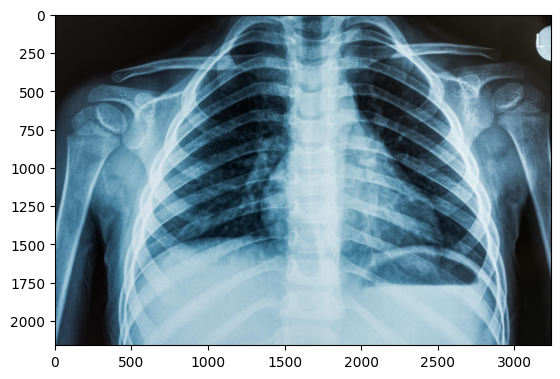

In [28]:
image_p_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(image_p_rgb)

In [29]:
cv2.imwrite('decrypted.png', original_image)

True